In [1]:
import os
import scanpy as sc
import anndata
import scvi
import torch

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

/Users/bms20/anaconda3/envs/scvi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([1.], device='mps:0')


In [7]:
# from scanpy.datasets import pbmc68k_reduced
# ad = pbmc68k_reduced()
ad=anndata.read_h5ad(os.path.expanduser("~/Downloads/hpo.h5ad"))
# sc.pp.normalize_total(ad)
# sc.pp.scale(ad)
## Normalise to range of 0-1 with sklearn sparse matrix
# X = ad.raw.X
# from sklearn.preprocessing import MaxAbsScaler
# X = MaxAbsScaler().fit_transform(X)

## MUST round to mimic RNA read counts: https://discourse.scverse.org/t/scvi-model-scvi-input-values/2233/2
ad.layers["counts"] = round(ad.X.copy()*1000)  

# sc.pp.normalize_total(ad, target_sum=1e4)
# sc.pp.log1p(ad)
ad.raw = ad
sc.pp.filter_cells(ad,min_genes=1)


# from sklearn.preprocessing import normalize
# X = normalize(X, norm='l1', axis=1)

/Users/bms20/anaconda3/envs/scvi/lib/python3.12/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


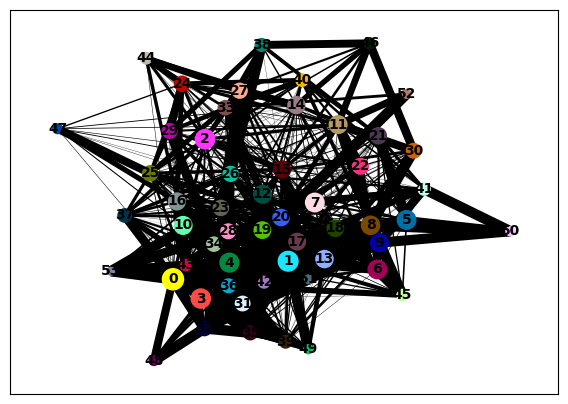

In [17]:
sc.pp.neighbors(ad)
sc.tl.leiden(ad)
sc.tl.paga(ad)
sc.pl.paga(ad)

In [18]:
# sc.tl.embedding_density(ad)
# sc.pl.embedding_density(ad)
# sc.pp.neighbors(ad)
# sc.tl.diffmap(ad)
# sc.pl.diffmap(ad)

# sc.tl.dendrogram(ad, groupby="ancestor_name_abnormality")
# sc.pl.dendrogram(ad, groupby="ancestor_name_abnormality")
# sc.pl.clustermap(ad)
ad


AnnData object with n_obs × n_vars = 11044 × 5003
    obs: 'orig.ident', 'nCount_score', 'nFeature_score', 'id', 'disease_id', 'disease_name', 'qualifier', 'reference', 'evidence', 'onset', 'frequency', 'sex', 'modifier', 'aspect', 'biocuration', 'definition', 'ancestor', 'ancestor_name', 'ancestor_name_abnormality', 'disease_db', 'hpo_name', 'id_type', 'id_name', 'n_genes', 'q.B.cell', 'q.GABAergic.neuron', 'q.Mueller.cell', 'q.Purkinje.cell', 'q.Schwann.cell', 'q.Sertoli.cell', 'q.T.cell', 'q.acinar.cell', 'q.alternatively.activated.macrophage', 'q.amacrine.cell', 'q.astrocyte', 'q.basal.cell', 'q.bipolar.neuron', 'q.brush.cell', 'q.cardiac.muscle.cell', 'q.cell.of.skeletal.muscle', 'q.chondrocyte', 'q.chorionic.trophoblast.cell', 'q.chromaffin.cell', 'q.ciliated.epithelial.cell', 'q.cord.blood.hematopoietic.stem.cell', 'q.corneal.epithelial.cell', 'q.cortical.cell.of.adrenal.gland', 'q.dendritic.cell', 'q.embryonic.stem.cell', 'q.endocardial.cell', 'q.endocrine.cell', 'q.endothelial

In [42]:
# https://docs.scvi-tools.org/en/stable/api/user.html
base_model = scvi.model.SCVI
base_model.setup_anndata(
    ad, 
    layer="counts",
    # categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["nFeature_score"]
)
model = base_model(
    adata=ad,
    n_latent=50,
    # n_layers=2,
    # n_hidden=128*8,
    # latent_distribution="ln"
)


### Tune model hyperparameters
# from ray import tune
# from scvi import autotune
# scvi_tuner = autotune.ModelTuner(model)
# scvi_tuner.info()
# search_space = {
#     "n_hidden": tune.choice([64, 128, 256]),
#     "n_layers": tune.choice([1, 2, 3]),
#     "lr": tune.loguniform(1e-4, 1e-2),
# }
# model1 = {
#     "n_hidden": 64,
#     "n_layers": 1,
#     "lr": 0.001,
# }
# model2 = {
#     "n_hidden": 64,
#     "n_layers": 3,
#     "lr": 0.0001,
# }
# ray.init(log_to_driver=False)
# results = scvi_tuner.fit(
#     ad,
#     metric="validation_loss",
#     search_space=search_space,
#     num_samples=5,
#     max_epochs=100,
#     resources={"cpu": 10, "gpu": 1},
# )


In [43]:
# import os
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = '1'
model.train(load_sparse_tensor=True, early_stopping=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/bms20/anaconda3/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 396/400:  99%|█████████▉| 396/400 [31:38<00:19,  4.79s/it, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.09e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1252.016. Signaling Trainer to stop.


In [44]:
SCVI_LATENT_KEY = "X_scVI"
latent = model.get_latent_representation()
ad.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(11044, 50)

In [45]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(ad, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(ad)
# sc.tl.tsne(ad, use_rep=SCVI_LATENT_KEY)

/Users/bms20/anaconda3/envs/scvi/lib/python3.12/site-packages/matplotlib/colors.py:1370: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


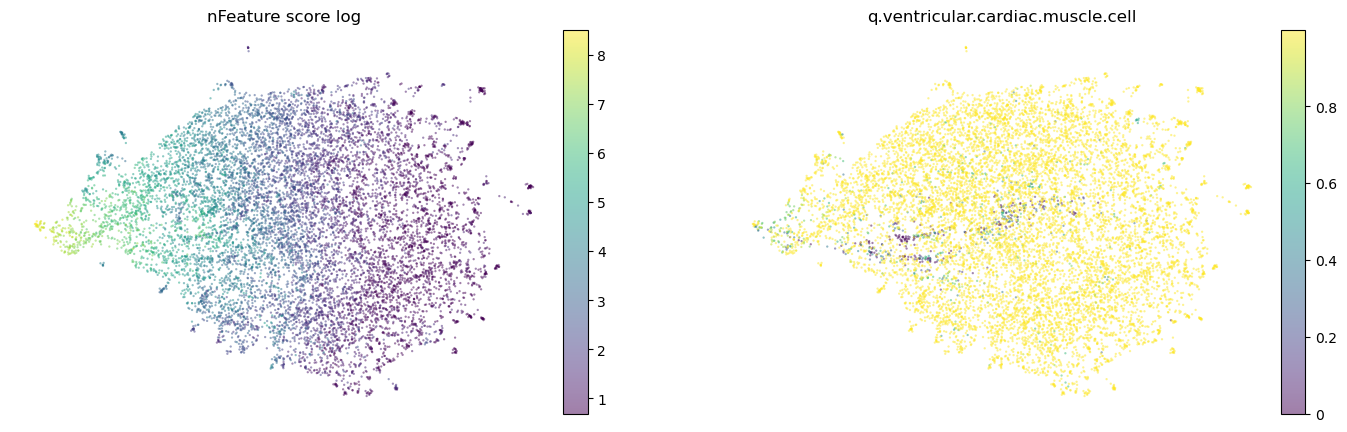

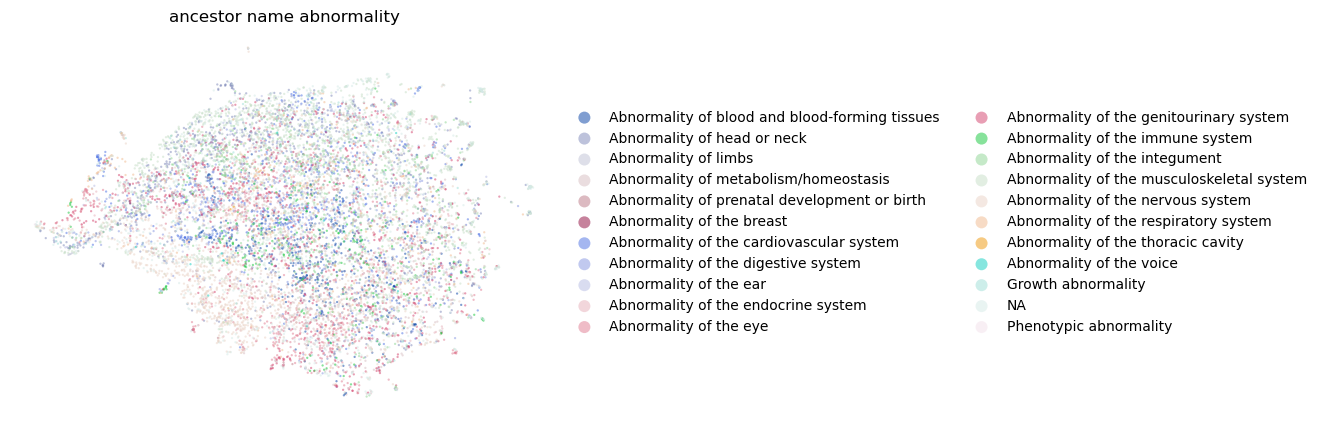

In [46]:
import numpy as np
ad.obs["nFeature_score_log"] =  ad.obs["nFeature_score"].apply(lambda x: np.log1p(x))
basis = "umap"
fig = sc.pl.scatter(
    ad,
    basis=basis,
    alpha=.5,
    color=["nFeature_score_log","q.ventricular.cardiac.muscle.cell"],
    frameon=False
)
fig = sc.pl.scatter(
    ad,
    basis=basis,
    alpha=.5,
    color=["ancestor_name_abnormality"],
    frameon=False
)

In [87]:
import plotly.tools as tls

plotly_fig = tls.mpl_to_plotly(fig)
plotly_fig

<11044x11044 sparse matrix of type '<class 'numpy.float32'>'
	with 222706 stored elements in Compressed Sparse Row format>

In [67]:
sc.pp.neighbors(ad, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(ad,  n_components=3)

In [68]:
spring_3D

{0: array([-0.14192282,  0.31434655, -0.13418142]),
 1: array([-0.25119072,  0.25032502, -0.25720137]),
 2: array([0.09402323, 0.0784054 , 0.0414509 ]),
 3: array([-0.1134202 ,  0.33053616, -0.12477548]),
 4: array([-0.03012699,  0.10112476, -0.04888291]),
 5: array([-0.18520366,  0.36730194, -0.1157754 ]),
 6: array([-0.04060537,  0.16351241,  0.09427064]),
 7: array([ 0.02073091,  0.00707571, -0.1021304 ]),
 8: array([0.00341794, 0.07794008, 0.12148891]),
 9: array([ 0.00978712, -0.09029175, -0.19761397]),
 10: array([ 0.29357976, -0.06723832, -0.3126156 ]),
 11: array([0.22404999, 0.14362232, 0.24227925]),
 12: array([ 0.00293428,  0.02515457, -0.11517797]),
 13: array([0.08748893, 0.24656306, 0.25546739]),
 14: array([-0.08732755, -0.20237108,  0.03414365]),
 15: array([ 0.37358516, -0.1207478 , -0.17005235]),
 16: array([-0.65016037, -0.7979992 , -0.2249936 ]),
 17: array([ 0.23623188,  0.01567949, -0.21062985]),
 18: array([ 0.49890143, -0.79962873,  0.1023427 ]),
 19: array([ 0.

In [66]:
import networkx as nx 
import plotly.graph_objects as go
import pandas as pd

## Create networkx graph from connectivties matrix 
Num_nodes = 10000
G = nx.Graph(ad.obsp["connectivities"][:Num_nodes,:Num_nodes])
spring_3D = nx.spring_layout(G,dim=3, seed=18)
#an example node coordinate
spring_3D[4]
#we need to seperate the X,Y,Z coordinates for Plotly
x_nodes = [spring_3D[i][0] for i in range(Num_nodes)]# x-coordinates of nodes
y_nodes = [spring_3D[i][1] for i in range(Num_nodes)]# y-coordinates
z_nodes = [spring_3D[i][2] for i in range(Num_nodes)]# z-coordinates
edge_list = G.edges()
#we  need to create lists that contain the starting and ending coordinates of each edge.
x_edges=[]
y_edges=[]
z_edges=[]
#need to fill these with all of the coordiates
for edge in edge_list:
    #format: [beginning,ending,None]
    x_coords = [spring_3D[edge[0]][0],spring_3D[edge[1]][0],None]
    x_edges += x_coords
    y_coords = [spring_3D[edge[0]][1],spring_3D[edge[1]][1],None]
    y_edges += y_coords
    z_coords = [spring_3D[edge[0]][2],spring_3D[edge[1]][2],None]
    z_edges += z_coords

KeyboardInterrupt: 

In [79]:
# melt matrix into long form

connectivities = pd.DataFrame(ad.obsp["connectivities"][:Num_nodes,:Num_nodes].toarray()).melt()
connectivities


,variable,value
0,0,0.000000
1,0,0.000000
2,0,0.000000
3,0,0.778146
4,0,0.000000
...,...,...
99999995,9999,0.000000
99999996,9999,0.000000
99999997,9999,0.000000
99999998,9999,1.000000


In [ ]:
px.

In [73]:
import plotly.express as px
px.scatter_3d(data_frame=ad.obsm['X_umap'],x=0,y=1,z=2)
px.(x=x_edges,y=y_edges,z=z_edges)

In [65]:
#create a trace for the edges

trace_edges = go.Scatter3d(x=x_edges,
                        y=y_edges,
                        z=z_edges,
                        mode='lines',
                        line=dict(color='black', width=2),
                        hoverinfo='none')
#create a trace for the nodes
trace_nodes = go.Scatter3d(x=x_nodes,
                         y=y_nodes,
                        z=z_nodes,
                        mode='markers',
                        hoverinfo='text')
#we need to set the axis for the plot 
axis = dict(showbackground=False,
            showline=False,
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            title='')
#also need to create the layout for our plot
layout = go.Layout(title="",
                width=650,
                height=625,
                showlegend=False,
                scene=dict(xaxis=dict(axis),
                        yaxis=dict(axis),
                        zaxis=dict(axis),
                        ),
                margin=dict(t=100),
                hovermode='closest')
#Include the traces we want to plot and create a figure
data = [trace_edges, trace_nodes]
fig = go.Figure(data=data, layout=layout)

fig.show()



In [ ]:

# embedding_df

,orig.ident,nCount_score,nFeature_score,id,disease_id,disease_name,qualifier,reference,evidence,onset,...,q.trophoblast.cell,q.trophoblast.giant.cell,q.type.II.pneumocyte,q.ventricular.cardiac.muscle.cell,q.visceromotor.neuron,top_celltype,score_snn_res.0.8,seurat_clusters,x,y
HP:0000001,0,28996.419444,4978,HP:0000001,NA,NA,NA,NA,NA,NA,...,0.999999,0.999999,1.0,1.00000,0.999999,ciliated epithelial cell,19,19,33.198307,27.775681
HP:0000002,0,8732.554762,1495,HP:0000002,OMIM:144750,"Hyperostosis, endosteal",NOT,OMIM:144750,TAS,,...,0.999999,0.999999,1.0,1.00000,0.999999,mesenchymal stem cell,14,14,54.675365,93.233971
HP:0000003,0,325.750000,93,HP:0000003,OMIM:107480,Townes-Brocks syndrome 1,,OMIM:107480,IEA,,...,0.999999,0.999999,1.0,1.00000,0.999999,metanephric podocyte,25,25,40.564610,85.063751
HP:0000005,0,39820.841667,4648,HP:0000005,NA,NA,NA,NA,NA,NA,...,0.999999,0.999999,1.0,1.00000,0.999999,innate lymphoid cell,19,19,35.389614,56.385567
HP:0000006,0,15326.453193,1920,HP:0000006,OMIM:619340,Developmental and epileptic encephalopathy 96,,PMID:31675180,PCS,,...,0.848977,0.999999,1.0,0.54919,0.999999,lens fiber cell,27,27,-3.759573,111.937866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HP:6000133,0,10.000000,1,HP:6000133,OMIM:250800,Methemoglobinemia due to deficiency of methemo...,,PMID:8874222,PCS,,...,0.999999,0.999999,1.0,1.00000,0.999999,GABAergic neuron,3,3,34.638607,81.758522
HP:6000134,0,15.000000,1,HP:6000134,OMIM:614307,Alpha-methylacyl-CoA racemase deficiency,,PMID:10655068,PCS,,...,0.999999,0.999999,1.0,1.00000,0.999999,gastric goblet cell,9,9,35.001492,81.385910
HP:6000147,0,4.000000,1,HP:6000147,OMIM:618156,Squalene synthase deficiency,,PMID:32027475,PCS,,...,0.999999,0.999999,1.0,1.00000,0.999999,cortical cell of adrenal gland,3,3,34.628735,82.256561
HP:6000158,0,22.000000,1,HP:6000158,OMIM:257220,"Niemann-pick disease, type C1",,PMID:25665455,PCS,,...,0.999999,0.999999,1.0,1.00000,0.999999,cortical cell of adrenal gland,9,9,34.967388,81.762451
